# 1. Import and Install Dependencies

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
os.chdir("C:/Users/GOAT Morad/Documents/GitHub/graduationProject2023")

# 2. Keypoints Exploration using MP

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
class point():
    def __init__(self, x, y, z):
        self.x = x 
        self.y = y
        self.z = z

### Making the connections look a little bit better

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
#         plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

KeyboardInterrupt: 

In [10]:
results

mediapipe.python.solution_base.SolutionOutputs

# 3. Extract and Preprocess Keypoints

In [11]:
len(results.right_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [13]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [14]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [15]:
def calculate_distance(point1, point2):
    x = abs(point1.x - point2.x)
    y = abs(point1.y - point2.y)
    z = abs(point1.z - point2.z)
    p = point(x,y,z)
    return p

In [16]:
def extract_midpoint(results):
    try:
        left_shoulder = results.pose_landmarks.landmark[11]
        right_shoulder = results.pose_landmarks.landmark[12]
        x = (left_shoulder.x + right_shoulder.x)/2
        y = (left_shoulder.y + right_shoulder.y)/2
        z = (left_shoulder.z + right_shoulder.z)/2
        visiblity = max(left_shoulder.visibility, right_shoulder.visibility)
        mid_point = point(x,y,z)
        return mid_point
    except:
        pass

In [17]:
def extract_keypoints(results, midpoint):
#     for(res in results.pose_landmarks.landmark):
#         point = point(res.x,res.y,res.z)
#         distances = calculate_distance(point, midpoint)
    
    # POSE LANDMARKS
    if results.pose_landmarks:
        pose = []
        for res in results.pose_landmarks.landmark:
            p = point(res.x, res.y, res.z)
            distances = calculate_distance(p, midpoint)
            pose.extend([distances.x, distances.y, distances.z])
        pose = np.array(pose).flatten()
    else:
        pose = np.zeros(33*3)
    
#     # FACE LANDMARKS
#     if results.face_landmarks:
#         face = []
#         for res in results.face_landmarks.landmark:
#             p = point(res.x, res.y, res.z)
#             distances = calculate_distance(p, midpoint)
#             face.extend([distances.x, distances.y, distances.z])
#         face = np.array(face).flatten()
#     else:
#         face = np.zeros(468*3)
    
    # LEFT HAND LANDMARKS
    if results.left_hand_landmarks:
        lh = []
        for res in results.left_hand_landmarks.landmark:
            p = point(res.x, res.y, res.z)
            distances = calculate_distance(p, midpoint)
            lh.extend([distances.x, distances.y, distances.z])
        lh = np.array(lh).flatten()
    else:
        lh = np.zeros(21*3)

    # RIGHT HAND LANDMARKS
    if results.right_hand_landmarks:
        rh = []
        for res in results.right_hand_landmarks.landmark:
            p = point(res.x, res.y, res.z)
            distances = calculate_distance(p, midpoint)
            rh.extend([distances.x, distances.y, distances.z])
        rh = np.array(rh).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])

In [18]:
33*3 + 468*3 + 21*3 + 21*3

1629

In [19]:
midpoint = extract_midpoint(results)

In [20]:
result_test = extract_keypoints(results, midpoint)

In [21]:
results.pose_landmarks.landmark[0]

x: 0.6852022
y: 0.4019101
z: -1.1764443
visibility: 0.99898136

In [22]:
result_test.shape

(225,)

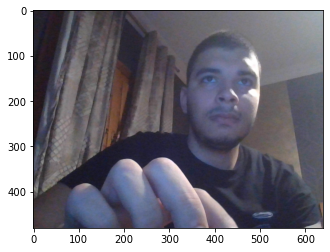

In [23]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 4. Setting up Dataset Folders

In [24]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Dynamic_dataset2') 

# Actions that we try to detect
actions = np.array(['Dance', 'Angry', 'Sleep'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [25]:
#Folder creation
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [26]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                midpoint = extract_midpoint(results)
                keypoints = extract_keypoints(results,midpoint)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [28]:
label_map = {label:num for num, label in enumerate(actions)}

In [29]:
label_map

{'Dance': 0, 'Angry': 1, 'Sleep': 2}

In [30]:
sequences, labels = [], []
#Loop on all folders
for action in actions:
    #Loop on all sequences (videos)
    for sequence in range(no_sequences):
        window = []
        #Loop on all frames on that video
        for frame_num in range(sequence_length):
            #Load that npy array and append them to the window varialbe
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [31]:
np.array(sequences).shape

(90, 30, 225)

In [32]:
X = np.array(sequences)

In [33]:
y = to_categorical(labels).astype(int)

In [34]:
X.shape

(90, 30, 225)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [36]:
y_test.shape

(5, 3)

# 7. Build and Train the LSTM NN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [43]:
# For monitoring while the model is training
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [44]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,225)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [45]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [46]:
model.fit(X_train, y_train, epochs = 2000, callbacks = [tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 43ms/step - loss: 1.0959 - categorical_accuracy: 0.4941
Epoch 2/2000
3/3 [==============================] - 0s 32ms/step - loss: 1.0608 - categorical_accuracy: 0.4824
Epoch 3/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.9422 - categorical_accuracy: 0.7059
Epoch 4/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.9284 - categorical_accuracy: 0.6588
Epoch 5/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.6391 - categorical_accuracy: 0.6235
Epoch 6/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.7005 - categorical_accuracy: 0.6706
Epoch 7/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.6626 - categorical_accuracy: 0.8588
Epoch 8/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.5929 - categorical_accuracy: 0.8588
Epoch 9/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.4623 - categorical_accuracy: 0.7647
E

3/3 [==============================] - 0s 32ms/step - loss: 0.0330 - categorical_accuracy: 0.9882
Epoch 75/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0329 - categorical_accuracy: 0.9882
Epoch 76/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0326 - categorical_accuracy: 0.9882
Epoch 77/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0319 - categorical_accuracy: 0.9882
Epoch 78/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0315 - categorical_accuracy: 0.9882
Epoch 79/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.0322 - categorical_accuracy: 0.9882
Epoch 80/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0305 - categorical_accuracy: 0.9882
Epoch 81/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0294 - categorical_accuracy: 0.9882
Epoch 82/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0302 - categorical_accuracy: 0.9882
Epoch 

3/3 [==============================] - 0s 33ms/step - loss: 0.0778 - categorical_accuracy: 0.9765
Epoch 147/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.0757 - categorical_accuracy: 0.9765
Epoch 148/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0735 - categorical_accuracy: 0.9765
Epoch 149/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0696 - categorical_accuracy: 0.9765
Epoch 150/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.0694 - categorical_accuracy: 0.9882
Epoch 151/2000
3/3 [==============================] - 0s 34ms/step - loss: 1.2955 - categorical_accuracy: 0.9412
Epoch 152/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.3010 - categorical_accuracy: 0.8706
Epoch 153/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.4502 - categorical_accuracy: 0.8353
Epoch 154/2000
3/3 [==============================] - 0s 32ms/step - loss: 0.3548 - categorical_accuracy: 0.952

3/3 [==============================] - 0s 47ms/step - loss: 0.0947 - categorical_accuracy: 0.9765
Epoch 219/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0904 - categorical_accuracy: 0.9765
Epoch 220/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.0880 - categorical_accuracy: 0.9765
Epoch 221/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0852 - categorical_accuracy: 0.9765
Epoch 222/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0826 - categorical_accuracy: 0.9765
Epoch 223/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.0801 - categorical_accuracy: 0.9765
Epoch 224/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0777 - categorical_accuracy: 0.9882
Epoch 225/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.0761 - categorical_accuracy: 0.9882
Epoch 226/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0731 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 45ms/step - loss: 0.1064 - categorical_accuracy: 0.9765
Epoch 291/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0932 - categorical_accuracy: 0.9765
Epoch 292/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.0867 - categorical_accuracy: 0.9765
Epoch 293/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0858 - categorical_accuracy: 0.9882
Epoch 294/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0863 - categorical_accuracy: 0.9882
Epoch 295/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.0800 - categorical_accuracy: 0.9882
Epoch 296/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0781 - categorical_accuracy: 0.9882
Epoch 297/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0768 - categorical_accuracy: 0.9882
Epoch 298/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0751 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 45ms/step - loss: 0.0602 - categorical_accuracy: 0.9882
Epoch 363/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0594 - categorical_accuracy: 0.9882
Epoch 364/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0586 - categorical_accuracy: 0.9882
Epoch 365/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0579 - categorical_accuracy: 0.9882
Epoch 366/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0572 - categorical_accuracy: 0.9882
Epoch 367/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0567 - categorical_accuracy: 0.9882
Epoch 368/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0562 - categorical_accuracy: 0.9882
Epoch 369/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0557 - categorical_accuracy: 0.9882
Epoch 370/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0553 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 41ms/step - loss: 0.2739 - categorical_accuracy: 0.9765
Epoch 435/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.2626 - categorical_accuracy: 0.9765
Epoch 436/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.2485 - categorical_accuracy: 0.9647
Epoch 437/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.2353 - categorical_accuracy: 0.9765
Epoch 438/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.2199 - categorical_accuracy: 0.9765
Epoch 439/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.2061 - categorical_accuracy: 0.9647
Epoch 440/2000
3/3 [==============================] - 0s 39ms/step - loss: 0.1904 - categorical_accuracy: 0.9647
Epoch 441/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.1765 - categorical_accuracy: 0.9765
Epoch 442/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.1652 - categorical_accuracy: 0.976

3/3 [==============================] - 0s 40ms/step - loss: 0.0432 - categorical_accuracy: 0.9882
Epoch 507/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.0427 - categorical_accuracy: 0.9882
Epoch 508/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0425 - categorical_accuracy: 0.9882
Epoch 509/2000
3/3 [==============================] - 0s 41ms/step - loss: 0.0422 - categorical_accuracy: 0.9882
Epoch 510/2000
3/3 [==============================] - 0s 42ms/step - loss: 0.0420 - categorical_accuracy: 0.9882
Epoch 511/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0418 - categorical_accuracy: 0.9882
Epoch 512/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0414 - categorical_accuracy: 0.9882
Epoch 513/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0414 - categorical_accuracy: 0.9882
Epoch 514/2000
3/3 [==============================] - 0s 40ms/step - loss: 0.0409 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 46ms/step - loss: 12.6711 - categorical_accuracy: 0.7412
Epoch 579/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.7553 - categorical_accuracy: 0.3412
Epoch 580/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.8312 - categorical_accuracy: 0.3294
Epoch 581/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.6890 - categorical_accuracy: 0.3294
Epoch 582/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.5376 - categorical_accuracy: 0.3412
Epoch 583/2000
3/3 [==============================] - 0s 47ms/step - loss: 1.3601 - categorical_accuracy: 0.3647
Epoch 584/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.2038 - categorical_accuracy: 0.4353
Epoch 585/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.0957 - categorical_accuracy: 0.4706
Epoch 586/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.0447 - categorical_accuracy: 0.49

3/3 [==============================] - 0s 46ms/step - loss: 0.1483 - categorical_accuracy: 0.9529
Epoch 651/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.1320 - categorical_accuracy: 0.9647
Epoch 652/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.1162 - categorical_accuracy: 0.9765
Epoch 653/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.1057 - categorical_accuracy: 0.9765
Epoch 654/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0998 - categorical_accuracy: 0.9765
Epoch 655/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0952 - categorical_accuracy: 0.9882
Epoch 656/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0921 - categorical_accuracy: 0.9882
Epoch 657/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0874 - categorical_accuracy: 0.9882
Epoch 658/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0823 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 47ms/step - loss: 0.0177 - categorical_accuracy: 0.9882
Epoch 723/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0159 - categorical_accuracy: 0.9882
Epoch 724/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.0124 - categorical_accuracy: 1.0000
Epoch 725/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.0114 - categorical_accuracy: 0.9882
Epoch 726/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0081 - categorical_accuracy: 1.0000
Epoch 727/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.0143 - categorical_accuracy: 0.9882
Epoch 728/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.0169 - categorical_accuracy: 1.0000
Epoch 729/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0083 - categorical_accuracy: 1.0000
Epoch 730/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.0062 - categorical_accuracy: 1.000

3/3 [==============================] - 0s 46ms/step - loss: 3.0258e-05 - categorical_accuracy: 1.0000
Epoch 793/2000
3/3 [==============================] - 0s 47ms/step - loss: 2.9929e-05 - categorical_accuracy: 1.0000
Epoch 794/2000
3/3 [==============================] - 0s 47ms/step - loss: 2.9468e-05 - categorical_accuracy: 1.0000
Epoch 795/2000
3/3 [==============================] - 0s 45ms/step - loss: 2.9019e-05 - categorical_accuracy: 1.0000
Epoch 796/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.8791e-05 - categorical_accuracy: 1.0000
Epoch 797/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.8355e-05 - categorical_accuracy: 1.0000
Epoch 798/2000
3/3 [==============================] - 0s 47ms/step - loss: 2.7944e-05 - categorical_accuracy: 1.0000
Epoch 799/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.7603e-05 - categorical_accuracy: 1.0000
Epoch 800/2000
3/3 [==============================] - 0s 45ms/step - loss: 2.72

3/3 [==============================] - 0s 47ms/step - loss: 1.5624e-05 - categorical_accuracy: 1.0000
Epoch 863/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.5479e-05 - categorical_accuracy: 1.0000
Epoch 864/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.5363e-05 - categorical_accuracy: 1.0000
Epoch 865/2000
3/3 [==============================] - 0s 47ms/step - loss: 1.5264e-05 - categorical_accuracy: 1.0000
Epoch 866/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.5100e-05 - categorical_accuracy: 1.0000
Epoch 867/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.5015e-05 - categorical_accuracy: 1.0000
Epoch 868/2000
3/3 [==============================] - 0s 48ms/step - loss: 1.4905e-05 - categorical_accuracy: 1.0000
Epoch 869/2000
3/3 [==============================] - 0s 47ms/step - loss: 1.4819e-05 - categorical_accuracy: 1.0000
Epoch 870/2000
3/3 [==============================] - 0s 46ms/step - loss: 1.46

3/3 [==============================] - 0s 45ms/step - loss: 1.0097e-05 - categorical_accuracy: 1.0000
Epoch 933/2000
3/3 [==============================] - 0s 45ms/step - loss: 1.0054e-05 - categorical_accuracy: 1.0000
Epoch 934/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.0016e-05 - categorical_accuracy: 1.0000
Epoch 935/2000
3/3 [==============================] - 0s 46ms/step - loss: 9.9669e-06 - categorical_accuracy: 1.0000
Epoch 936/2000
3/3 [==============================] - 0s 44ms/step - loss: 9.9123e-06 - categorical_accuracy: 1.0000
Epoch 937/2000
3/3 [==============================] - 0s 45ms/step - loss: 9.8590e-06 - categorical_accuracy: 1.0000
Epoch 938/2000
3/3 [==============================] - 0s 47ms/step - loss: 9.8043e-06 - categorical_accuracy: 1.0000
Epoch 939/2000
3/3 [==============================] - 0s 45ms/step - loss: 9.7496e-06 - categorical_accuracy: 1.0000
Epoch 940/2000
3/3 [==============================] - 0s 45ms/step - loss: 9.72

3/3 [==============================] - 0s 55ms/step - loss: 7.2848e-06 - categorical_accuracy: 1.0000
Epoch 1003/2000
3/3 [==============================] - 0s 49ms/step - loss: 7.2553e-06 - categorical_accuracy: 1.0000
Epoch 1004/2000
3/3 [==============================] - 0s 48ms/step - loss: 7.2329e-06 - categorical_accuracy: 1.0000
Epoch 1005/2000
3/3 [==============================] - 0s 51ms/step - loss: 7.2034e-06 - categorical_accuracy: 1.0000
Epoch 1006/2000
3/3 [==============================] - 0s 49ms/step - loss: 7.1670e-06 - categorical_accuracy: 1.0000
Epoch 1007/2000
3/3 [==============================] - 0s 49ms/step - loss: 7.1389e-06 - categorical_accuracy: 1.0000
Epoch 1008/2000
3/3 [==============================] - 0s 52ms/step - loss: 7.1081e-06 - categorical_accuracy: 1.0000
Epoch 1009/2000
3/3 [==============================] - 0s 51ms/step - loss: 7.0842e-06 - categorical_accuracy: 1.0000
Epoch 1010/2000
3/3 [==============================] - 0s 49ms/step - lo

3/3 [==============================] - 0s 46ms/step - loss: 5.5321e-06 - categorical_accuracy: 1.0000
Epoch 1072/2000
3/3 [==============================] - 0s 44ms/step - loss: 5.5082e-06 - categorical_accuracy: 1.0000
Epoch 1073/2000
3/3 [==============================] - 0s 45ms/step - loss: 5.4914e-06 - categorical_accuracy: 1.0000
Epoch 1074/2000
3/3 [==============================] - 0s 44ms/step - loss: 5.4676e-06 - categorical_accuracy: 1.0000
Epoch 1075/2000
3/3 [==============================] - 0s 45ms/step - loss: 5.4451e-06 - categorical_accuracy: 1.0000
Epoch 1076/2000
3/3 [==============================] - 0s 44ms/step - loss: 5.4311e-06 - categorical_accuracy: 1.0000
Epoch 1077/2000
3/3 [==============================] - 0s 45ms/step - loss: 5.4073e-06 - categorical_accuracy: 1.0000
Epoch 1078/2000
3/3 [==============================] - 0s 47ms/step - loss: 5.3862e-06 - categorical_accuracy: 1.0000
Epoch 1079/2000
3/3 [==============================] - 0s 53ms/step - lo

3/3 [==============================] - 0s 46ms/step - loss: 4.3388e-06 - categorical_accuracy: 1.0000
Epoch 1141/2000
3/3 [==============================] - 0s 45ms/step - loss: 4.3262e-06 - categorical_accuracy: 1.0000
Epoch 1142/2000
3/3 [==============================] - 0s 46ms/step - loss: 4.3122e-06 - categorical_accuracy: 1.0000
Epoch 1143/2000
3/3 [==============================] - 0s 45ms/step - loss: 4.3009e-06 - categorical_accuracy: 1.0000
Epoch 1144/2000
3/3 [==============================] - 0s 47ms/step - loss: 4.2813e-06 - categorical_accuracy: 1.0000
Epoch 1145/2000
3/3 [==============================] - 0s 43ms/step - loss: 4.2743e-06 - categorical_accuracy: 1.0000
Epoch 1146/2000
3/3 [==============================] - 0s 45ms/step - loss: 4.2519e-06 - categorical_accuracy: 1.0000
Epoch 1147/2000
3/3 [==============================] - 0s 44ms/step - loss: 4.2406e-06 - categorical_accuracy: 1.0000
Epoch 1148/2000
3/3 [==============================] - 0s 44ms/step - lo

3/3 [==============================] - 0s 47ms/step - loss: 3.4470e-06 - categorical_accuracy: 1.0000
Epoch 1210/2000
3/3 [==============================] - 0s 45ms/step - loss: 3.4372e-06 - categorical_accuracy: 1.0000
Epoch 1211/2000
3/3 [==============================] - 0s 45ms/step - loss: 3.4274e-06 - categorical_accuracy: 1.0000
Epoch 1212/2000
3/3 [==============================] - 0s 44ms/step - loss: 3.4217e-06 - categorical_accuracy: 1.0000
Epoch 1213/2000
3/3 [==============================] - 0s 47ms/step - loss: 3.4077e-06 - categorical_accuracy: 1.0000
Epoch 1214/2000
3/3 [==============================] - 0s 47ms/step - loss: 3.4021e-06 - categorical_accuracy: 1.0000
Epoch 1215/2000
3/3 [==============================] - 0s 45ms/step - loss: 3.3895e-06 - categorical_accuracy: 1.0000
Epoch 1216/2000
3/3 [==============================] - 0s 45ms/step - loss: 3.3797e-06 - categorical_accuracy: 1.0000
Epoch 1217/2000
3/3 [==============================] - 0s 46ms/step - lo

3/3 [==============================] - 0s 47ms/step - loss: 2.8118e-06 - categorical_accuracy: 1.0000
Epoch 1279/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.8047e-06 - categorical_accuracy: 1.0000
Epoch 1280/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.7949e-06 - categorical_accuracy: 1.0000
Epoch 1281/2000
3/3 [==============================] - 0s 47ms/step - loss: 2.7893e-06 - categorical_accuracy: 1.0000
Epoch 1282/2000
3/3 [==============================] - 0s 48ms/step - loss: 2.7795e-06 - categorical_accuracy: 1.0000
Epoch 1283/2000
3/3 [==============================] - 0s 47ms/step - loss: 2.7683e-06 - categorical_accuracy: 1.0000
Epoch 1284/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.7641e-06 - categorical_accuracy: 1.0000
Epoch 1285/2000
3/3 [==============================] - 0s 46ms/step - loss: 2.7529e-06 - categorical_accuracy: 1.0000
Epoch 1286/2000
3/3 [==============================] - 0s 47ms/step - lo

3/3 [==============================] - 0s 45ms/step - loss: 2.3013e-06 - categorical_accuracy: 1.0000
Epoch 1348/2000
3/3 [==============================] - 0s 43ms/step - loss: 2.2929e-06 - categorical_accuracy: 1.0000
Epoch 1349/2000
3/3 [==============================] - 0s 44ms/step - loss: 2.2845e-06 - categorical_accuracy: 1.0000
Epoch 1350/2000
3/3 [==============================] - 0s 41ms/step - loss: 2.2775e-06 - categorical_accuracy: 1.0000
Epoch 1351/2000
3/3 [==============================] - 0s 40ms/step - loss: 2.2747e-06 - categorical_accuracy: 1.0000
Epoch 1352/2000
3/3 [==============================] - 0s 40ms/step - loss: 2.2635e-06 - categorical_accuracy: 1.0000
Epoch 1353/2000
3/3 [==============================] - 0s 40ms/step - loss: 2.2578e-06 - categorical_accuracy: 1.0000
Epoch 1354/2000
3/3 [==============================] - 0s 39ms/step - loss: 2.2550e-06 - categorical_accuracy: 1.0000
Epoch 1355/2000
3/3 [==============================] - 0s 41ms/step - lo

3/3 [==============================] - 0s 40ms/step - loss: 1.9017e-06 - categorical_accuracy: 1.0000
Epoch 1417/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.8988e-06 - categorical_accuracy: 1.0000
Epoch 1418/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.8904e-06 - categorical_accuracy: 1.0000
Epoch 1419/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.8848e-06 - categorical_accuracy: 1.0000
Epoch 1420/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.8820e-06 - categorical_accuracy: 1.0000
Epoch 1421/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.8764e-06 - categorical_accuracy: 1.0000
Epoch 1422/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.8694e-06 - categorical_accuracy: 1.0000
Epoch 1423/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.8624e-06 - categorical_accuracy: 1.0000
Epoch 1424/2000
3/3 [==============================] - 0s 40ms/step - lo

3/3 [==============================] - 0s 40ms/step - loss: 1.5763e-06 - categorical_accuracy: 1.0000
Epoch 1486/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.5735e-06 - categorical_accuracy: 1.0000
Epoch 1487/2000
3/3 [==============================] - 0s 44ms/step - loss: 1.5679e-06 - categorical_accuracy: 1.0000
Epoch 1488/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.5637e-06 - categorical_accuracy: 1.0000
Epoch 1489/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.5595e-06 - categorical_accuracy: 1.0000
Epoch 1490/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.5567e-06 - categorical_accuracy: 1.0000
Epoch 1491/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.5511e-06 - categorical_accuracy: 1.0000
Epoch 1492/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.5441e-06 - categorical_accuracy: 1.0000
Epoch 1493/2000
3/3 [==============================] - 0s 40ms/step - lo

3/3 [==============================] - 0s 41ms/step - loss: 1.3127e-06 - categorical_accuracy: 1.0000
Epoch 1555/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.3071e-06 - categorical_accuracy: 1.0000
Epoch 1556/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.3028e-06 - categorical_accuracy: 1.0000
Epoch 1557/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.3028e-06 - categorical_accuracy: 1.0000
Epoch 1558/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.2986e-06 - categorical_accuracy: 1.0000
Epoch 1559/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.2944e-06 - categorical_accuracy: 1.0000
Epoch 1560/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.2902e-06 - categorical_accuracy: 1.0000
Epoch 1561/2000
3/3 [==============================] - 0s 40ms/step - loss: 1.2860e-06 - categorical_accuracy: 1.0000
Epoch 1562/2000
3/3 [==============================] - 0s 44ms/step - lo

3/3 [==============================] - 0s 40ms/step - loss: 1.1023e-06 - categorical_accuracy: 1.0000
Epoch 1624/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0967e-06 - categorical_accuracy: 1.0000
Epoch 1625/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0939e-06 - categorical_accuracy: 1.0000
Epoch 1626/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0925e-06 - categorical_accuracy: 1.0000
Epoch 1627/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0883e-06 - categorical_accuracy: 1.0000
Epoch 1628/2000
3/3 [==============================] - 0s 41ms/step - loss: 1.0869e-06 - categorical_accuracy: 1.0000
Epoch 1629/2000
3/3 [==============================] - 0s 42ms/step - loss: 1.0841e-06 - categorical_accuracy: 1.0000
Epoch 1630/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.0813e-06 - categorical_accuracy: 1.0000
Epoch 1631/2000
3/3 [==============================] - 0s 40ms/step - lo

3/3 [==============================] - 0s 45ms/step - loss: 9.2841e-07 - categorical_accuracy: 1.0000
Epoch 1693/2000
3/3 [==============================] - 0s 46ms/step - loss: 9.2420e-07 - categorical_accuracy: 1.0000
Epoch 1694/2000
3/3 [==============================] - 0s 45ms/step - loss: 9.2280e-07 - categorical_accuracy: 1.0000
Epoch 1695/2000
3/3 [==============================] - 0s 46ms/step - loss: 9.2140e-07 - categorical_accuracy: 1.0000
Epoch 1696/2000
3/3 [==============================] - 0s 44ms/step - loss: 9.2140e-07 - categorical_accuracy: 1.0000
Epoch 1697/2000
3/3 [==============================] - 0s 46ms/step - loss: 9.1859e-07 - categorical_accuracy: 1.0000
Epoch 1698/2000
3/3 [==============================] - 0s 48ms/step - loss: 9.1438e-07 - categorical_accuracy: 1.0000
Epoch 1699/2000
3/3 [==============================] - 0s 46ms/step - loss: 9.1298e-07 - categorical_accuracy: 1.0000
Epoch 1700/2000
3/3 [==============================] - 0s 45ms/step - lo

3/3 [==============================] - 0s 46ms/step - loss: 7.8256e-07 - categorical_accuracy: 1.0000
Epoch 1762/2000
3/3 [==============================] - 0s 44ms/step - loss: 7.7975e-07 - categorical_accuracy: 1.0000
Epoch 1763/2000
3/3 [==============================] - 0s 46ms/step - loss: 7.7835e-07 - categorical_accuracy: 1.0000
Epoch 1764/2000
3/3 [==============================] - 0s 45ms/step - loss: 7.7695e-07 - categorical_accuracy: 1.0000
Epoch 1765/2000
3/3 [==============================] - 0s 45ms/step - loss: 7.7695e-07 - categorical_accuracy: 1.0000
Epoch 1766/2000
3/3 [==============================] - 0s 46ms/step - loss: 7.7274e-07 - categorical_accuracy: 1.0000
Epoch 1767/2000
3/3 [==============================] - 0s 48ms/step - loss: 7.7274e-07 - categorical_accuracy: 1.0000
Epoch 1768/2000
3/3 [==============================] - 0s 46ms/step - loss: 7.6994e-07 - categorical_accuracy: 1.0000
Epoch 1769/2000
3/3 [==============================] - 0s 45ms/step - lo

3/3 [==============================] - 0s 48ms/step - loss: 6.5915e-07 - categorical_accuracy: 1.0000
Epoch 1831/2000
3/3 [==============================] - 0s 48ms/step - loss: 6.5634e-07 - categorical_accuracy: 1.0000
Epoch 1832/2000
3/3 [==============================] - 0s 50ms/step - loss: 6.5354e-07 - categorical_accuracy: 1.0000
Epoch 1833/2000
3/3 [==============================] - 0s 48ms/step - loss: 6.5354e-07 - categorical_accuracy: 1.0000
Epoch 1834/2000
3/3 [==============================] - 0s 50ms/step - loss: 6.5213e-07 - categorical_accuracy: 1.0000
Epoch 1835/2000
3/3 [==============================] - 0s 49ms/step - loss: 6.5213e-07 - categorical_accuracy: 1.0000
Epoch 1836/2000
3/3 [==============================] - 0s 50ms/step - loss: 6.5073e-07 - categorical_accuracy: 1.0000
Epoch 1837/2000
3/3 [==============================] - 0s 50ms/step - loss: 6.4793e-07 - categorical_accuracy: 1.0000
Epoch 1838/2000
3/3 [==============================] - 0s 49ms/step - lo

3/3 [==============================] - 0s 43ms/step - loss: 5.6378e-07 - categorical_accuracy: 1.0000
Epoch 1900/2000
3/3 [==============================] - 0s 40ms/step - loss: 5.6238e-07 - categorical_accuracy: 1.0000
Epoch 1901/2000
3/3 [==============================] - 0s 39ms/step - loss: 5.6238e-07 - categorical_accuracy: 1.0000
Epoch 1902/2000
3/3 [==============================] - 0s 38ms/step - loss: 5.6098e-07 - categorical_accuracy: 1.0000
Epoch 1903/2000
3/3 [==============================] - 0s 39ms/step - loss: 5.6098e-07 - categorical_accuracy: 1.0000
Epoch 1904/2000
3/3 [==============================] - 0s 40ms/step - loss: 5.5817e-07 - categorical_accuracy: 1.0000
Epoch 1905/2000
3/3 [==============================] - 0s 39ms/step - loss: 5.5817e-07 - categorical_accuracy: 1.0000
Epoch 1906/2000
3/3 [==============================] - 0s 41ms/step - loss: 5.5677e-07 - categorical_accuracy: 1.0000
Epoch 1907/2000
3/3 [==============================] - 0s 39ms/step - lo

3/3 [==============================] - 0s 40ms/step - loss: 4.7964e-07 - categorical_accuracy: 1.0000
Epoch 1969/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.7823e-07 - categorical_accuracy: 1.0000
Epoch 1970/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.7823e-07 - categorical_accuracy: 1.0000
Epoch 1971/2000
3/3 [==============================] - 0s 39ms/step - loss: 4.7823e-07 - categorical_accuracy: 1.0000
Epoch 1972/2000
3/3 [==============================] - 0s 39ms/step - loss: 4.7543e-07 - categorical_accuracy: 1.0000
Epoch 1973/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.7543e-07 - categorical_accuracy: 1.0000
Epoch 1974/2000
3/3 [==============================] - 0s 39ms/step - loss: 4.7262e-07 - categorical_accuracy: 1.0000
Epoch 1975/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.7262e-07 - categorical_accuracy: 1.0000
Epoch 1976/2000
3/3 [==============================] - 0s 42ms/step - lo

# 8. Make Predictions

In [65]:
res = model.predict(X_test)

In [68]:
actions[np.argmax(res[4])]

'Sleep'

In [69]:
actions[np.argmax(y_test[4])]

'Sleep'

In [71]:
model.save('dynamic_first_iteration.h5')

# 9. Realtime Prediction

In [72]:
from tensorflow.keras.models import load_model

model = load_model('dynamic_first_iteration.h5')

In [73]:

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        midpoint = extract_midpoint(results)
        keypoints = extract_keypoints(results,midpoint)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti